# Local Sensitivity

```{admonition} Learning Objectives
After reading this chapter, you will be able to:
- Define local sensitivity and explain how it differs from global sensitivity
- Describe how local sensitivity can leak information about the data
- Use propose-test-release to safely apply local sensitivity
- Describe the smooth sensitivity framework
- Use the sample-and-aggregate framework to answer queries with arbitrary sensitivity
```


So far, we have seen only one measure of sensitivity: global sensitivity. Our definition for global sensitivity considers *any* two neighboring datasets. This seems pessimistic, since we're going to run our differentially private mechanisms on an *actual* dataset - shouldn't we consider neighbors of *that* dataset?

This is the intuition behind *local sensitivity* {cite}`nissim2007`: fix one of the two datasets to be the *actual* dataset being queried, and consider all of its neighbors. Formally, the local sensitivity of a function $f : \mathcal{D} \rightarrow \mathbb{R}$ at $x : \mathcal{D}$ is defined as:

```{prf:definition}
:label: local-sensitivity-def
\begin{align*}
LS(f, x) = \max_{x': d(x,x') \leq 1} \lvert f(x) - f(x') \rvert
\end{align*}
```

Notice that local sensitivity is a function of both the query ($f$) and the *actual* dataset ($x$). Unlike in the case of global sensitivity, we can't talk about the local sensitivity of a function without also considering the dataset *at which* that local sensitivity occurs.

## Local Sensitivity of the Mean

Local sensitivity allows us to place finite bounds on the sensitivity of some functions whose global sensitivity is difficult to bound. The mean function is one example. So far, we've calculated differentially private means by splitting the query into two queries: a differentially private sum (the numerator) and a differentially private count (the denominator). By sequential composition and post-processing, the quotient of these two results satisfies differential privacy.

Why do we do it this way? Because the amount the output of a mean query might change when a row is added to or removed from the dataset *depends on the size of the dataset*. If we want to bound the global sensitivity of a mean query, we have to assume the worst: a dataset of size 1. In this case, if the data attribute values lie between upper and lower bounds $u$ and $l$, the global sensitivity of the mean is just $\lvert u - l \lvert$. For large datasets, this is *extremely* pessimistic, and the "noisy sum over noisy count" approach is much better.

The situation is different for local sensitivity. In the worst case, we can add a new row to the dataset which contains the maximum value ($u$). Let $n = \lvert x \rvert$ (i.e. the size of the dataset). We start with the value of the mean:

\begin{align}
f(x) =& \frac{\sum_{i=1}^{n} x_i}{n}
\end{align}

Now we consider what happens when we add a row:

\begin{align}
\lvert f(x') - f(x) \rvert = & \bigg\lvert \frac{\sum_{i=1}^{n} x_i + u}{n+1} - \frac{\sum_{i=1}^{n} x_i}{n} \bigg\rvert \\
\leq& \bigg\lvert \frac{\sum_{i=1}^{n} x_i + u}{n+1} - \frac{\sum_{i=1}^{n} x_i}{n+1} \bigg\rvert \\
=& \bigg\lvert \frac{\sum_{i=1}^{n} x_i + u - \sum_{i=1}^{n} x_i}{n+1}\bigg\rvert \\
=& \bigg\lvert \frac{u}{n+1} \bigg\rvert \\
\end{align}

This local sensitivity measure is defined in terms of the actual dataset's size, which is not possible under global sensitivity.

## Achieving Differential Privacy via Local Sensitivity?

We have defined an alternative measure of sensitivity - but how do we use it? Can we just use the Laplace mechanism, in the same way as we did with global sensitivity? Does the following definition of $F$ satisfy $\epsilon$-differential privacy?

\begin{align}
F(x) = f(x) + \mathsf{Lap}\left(\frac{LS(f,x)}{\epsilon}\right)
\end{align}

No! Unfortunately not. Since $LS(f, x)$ itself depends on the dataset, if the analyst knows the local sensitivity of a query *at a particular dataset*, then the analyst may be able to infer some information about the dataset. It's therefore *not possible* to use local sensitivity directly to achieve differential privacy. For example, consider the bound on local sensitivity for the mean, defined above. If we know the local sensitivity at a particular $x$, we can infer the exact size of $x$ with *no noise*:

\begin{align}
\lvert x \rvert = \frac{b}{LS(f, x)} - 1
\end{align}

Moreover, keeping the local sensitivity secret from the analyst *doesn't help either*. It's possible to determine the scale of the noise from just a few query answers, and the analyst can use this value to infer the local sensitivity. Differential privacy is designed to protect the output of $f(x)$ - *not* of the sensitivity measure used in its definition.

Several approaches have been proposed for safely using local sensitivity. We'll explore these in the rest of this section.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import pandas as pd
import numpy as np

adult = pd.read_csv("adult_with_pii.csv")
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)
def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0


With auxiliary data, this can tell us something really sensitive. What if our query is: "Average score of people named Joe in the dataset with a 98% on the exam"? Then the size of the thing being averaged is sensitive!!

## Propose-test-release

The primary problem with local sensitivity is that the sensitivity itself reveals something about the data. What if we make the *sensitivity itself* differentially private? This is challenging to do directly, as there's often no finite bound on the global sensitivity of a function's local sensitivity. However, we can ask a differentially private question that gets at this value indirectly.

The *propose-test-release* framework {cite}`dwork2009` takes this approach. The framework first asks the analyst to *propose* an upper bound on the local sensitivity of the function being applied. Then, the framework runs a differentially private *test* to check that the dataset being queried is "far from" a dataset where local sensitivity is higher than the proposed bound. If the test passes, the framework *releases* a noisy result, with the noise calibrated to the proposed bound.

In order to answer the question of whether a dataset is "far from" one with high local sensitivity, we define the notion of *local sensitivity at distance $k$*. We write $A(f, x, k)$ to denote the maximum local sensitivity achievable for $f$ by taking $k$ steps away from the dataset $x$. Formally:

```{prf:definition}
:label: k-steps
\begin{align*}
A(f,x,k) = \max_{y: d(x,y) \leq k} LS(f, y)
\end{align*}
```

Now we're ready to define a query to answer the question: "how many steps are needed to achieve a local sensitivity greater than a given upper bound $b$?"

```{prf:definition}
:label: argmin
\begin{align*}
D(f, x, b) = \text{argmin}_k A(f, x, k) > b
\end{align*}
```

Finally, we define the propose-test-release framework (see [Barthe et al.](https://arxiv.org/abs/1407.2988), Figure 10), which satisfies $(\epsilon, \delta)$-differential privacy:

```{prf:definition}
:label: propose-test-release-def
1. Propose a target bound $b$ on local sensitivity. 
2. If $D(f, x, b) + \mathsf{Lap}(\frac{1}{\epsilon}) < \frac{\log(2/\delta)}{2\epsilon}$, return $\bot$.
3. Return $f(x)+Lap(\frac{b}{\epsilon})$
```

Notice that $D(f,x,b)$ has a *global* sensitivity of 1: adding or removing a row in $x$ might change the distance to a "high" local sensitivity by 1. Thus, adding Laplace noise scaled to $\frac{1}{\epsilon}$ yields a differentially private way to measure local sensitivity.

Why does this approach satisfy $(\epsilon, \delta)$-differential privacy (and not pure $\epsilon$-differential privacy)? It's because there's a non-zero chance of *passing the test by accident*. The noise added in step 2 might be large enough to pass the test, even though the value of $D(f,x,b)$ is actually *less* than the minimum distance required to satisfy differential privacy.

This failure mode is much closer to the catastrophic failure we saw from the "catastrophe mechanism" - with non-zero probability, the propose-test-release framework allows releasing a query answer with *far* too little noise to satisfy differential privacy. On the other hand, it's not nearly as bad as the catastrophe mechanism, since it never releases the answer with *no* noise.

Also note that the privacy cost of the framework is $(\epsilon, \delta)$ *even if* it returns $\bot$ (i.e. the privacy budget is consumed whether or not the analyst receives an answer).

Let's implement propose-test-release for our mean query. Recall that the local sensitivity for this query is $\big\lvert \frac{u}{n+1}\big\rvert$; the best way to increase this value is to make $n$ smaller. If we take $k$ steps from the dataset $x$, we can arrive at a local sensitivity of $\big\lvert \frac{u}{(n-k)+1}\big\rvert$. We can implement the framework in Python using the following code.

In [2]:
def ls_at_distance(df, u, k):
    return np.abs(u/(len(df) - k + 1))

def dist_to_high_ls(df, u, b):
    k = 0
    
    while ls_at_distance(df, u, k) < b:
        k += 1
    
    return k

In [3]:
def ptr_avg(df, u, b, epsilon, delta, logging=False):
    df_clipped = df.clip(upper=u)
    k = dist_to_high_ls(df_clipped, u, b)

    noisy_distance = laplace_mech(k, 1, epsilon)
    threshold = np.log(2/delta)/(2*epsilon)

    if logging:
        print(f"Noisy distance is {noisy_distance} and threshold is {threshold}")

    if noisy_distance >= threshold:
        return laplace_mech(df_clipped.mean(), b, epsilon)
    else:
        return None

In [4]:
df = adult['Age']
u = 100                    # set the upper bound on age to 100
epsilon = 1                # set epsilon = 1
delta = 1/(len(df)**2)     # set delta = 1/n^2
b = 0.005                  # propose a sensitivity of 0.005

ptr_avg(df, u, b, epsilon, delta, logging=True)

Noisy distance is 12560.551006055499 and threshold is 10.73744412245554


38.57550841249995

Keep in mind that local sensitivity isn't always better. For mean queries, our old strategy of splitting the query into two separate queries (a sum and a count), both with bounded global sensitivity, often works much better. We can implement the same mean query with global sensitivity:

In [5]:
def gs_avg(df, u, epsilon):
    df_clipped = df.clip(upper=u)
    
    noisy_sum = laplace_mech(df_clipped.sum(), u, .5*epsilon)
    noisy_count = laplace_mech(len(df_clipped), 1, .5*epsilon)
    
    return noisy_sum / noisy_count

In [6]:
gs_avg(adult['Age'], u, epsilon)

38.587733183959315

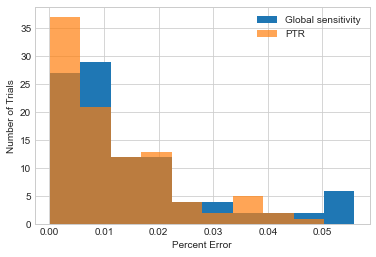

In [7]:
gs_results  = [pct_error(np.mean(adult['Age']), gs_avg(df, u, epsilon)) for i in range(100)]
ptr_results = [pct_error(np.mean(adult['Age']), ptr_avg(df, u, b, epsilon, delta)) for i in range(100)]

_, bins, _ = plt.hist(gs_results, label='Global sensitivity');
plt.hist(ptr_results, alpha=.7, label='PTR', bins=bins);
plt.xlabel('Percent Error')
plt.ylabel('Number of Trials')
plt.legend();

We might do slightly better with propose-test-release, but it's not a huge difference. Moreover, to use propose-test-release, the analyst has to propose a bound on sensitivity - and we've cheated by "magically" picking a decent value (0.005). In practice, the analyst would need to perform several queries to explore which values work - which will consume additional privacy budget.

## Smooth Sensitivity

Our second approach for leveraging local sensitivity is called *smooth sensitivity*, and is due to [Nissim, Raskhodnikova, and Smith](http://www.cse.psu.edu/~ads22/pubs/NRS07/NRS07-full-draft-v1.pdf) {cite}`nissim2007`. The *smooth sensitivity framework*, instantiated with Laplace noise, provides $(\epsilon, \delta)$-differential privacy:

```{prf:definition}
:label: smooth-sensitivity-def
1. Set $\beta = \frac{\epsilon}{2\log(2/\delta)}$
2. Let $S = \max_{k = 1, \dots, n} e^{-\beta k} A(f, x, k)$
3. Release $f(x) + \mathsf{Lap}\left(\frac{2S}{\epsilon}\right)$
```

The idea behind smooth sensitivity is to use a "smooth" approximation of local sensitivity, rather than local sensitivity itself, to calibrate the noise. The amount of smoothing is designed to prevent the unintentional release of information about the dataset that can happen when local sensitivity is used directly. Step 2 above performs the smoothing: it scales the local sensitivity of nearby datasets by an exponential function of their distance from the actual dataset, then takes the maximum scaled local sensitivity. The effect is that if a spike in local sensitivity exists in the neighborhood of $x$, that spike will be reflected in the smooth sensitivity of $x$ (and therefore the spike itself is "smoothed out," and doesn't reveal anything about the dataset). 

Smooth sensitivity has a significant advantage over propose-test-release: it doesn't require the analyst to propose a bound on sensitivity. For the analyst, using smooth sensitivity is just as easy as using global sensitivity. However, smooth sensitivity has two major drawbacks. First, smooth sensitivity is always larger than local sensitivity (by at least a factor of 2 - see step 3), so it may require adding quite a bit more noise than alternative frameworks like propose-test-release (or even global sensitivity). Second, calculating smooth sensitivity requires finding the maximum smoothed-out sensitivity over *all* possible values for $k$, which can be extremely challenging computationally. In many cases, it's possible to prove that considering a small number of values for $k$ is sufficient (for many functions, the exponentially decaying $e^{-\beta k}$ quickly overwhelms the growing value of $A(f, x, k)$), but such a property has to be proven for *each* function we want to use with smooth sensitivity.

As an example, let's consider the smooth sensitivity of the mean query we defined earlier.

Final sensitivity: 0.006142128861863522


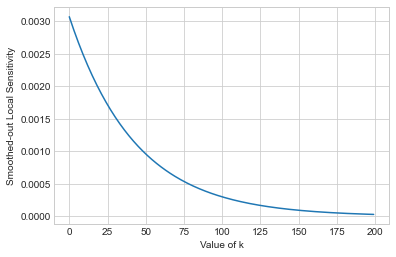

In [8]:
df = adult['Age']
epsilon = 1           # set epsilon = 1
delta = 1/len(df)**2  # set delta = 1/n^2

# Step 1: set beta
beta = epsilon / (2*np.log(2/delta))

# Step 2: compute smoothed-out sensitivity for various values of k
r = [np.exp(- beta * k) * ls_at_distance(df, u, k) for k in range(0,200)]
plt.plot(r);
plt.xlabel('Value of k')
plt.ylabel('Smoothed-out Local Sensitivity');

S = np.max(r)
sensitivity = 2*S
print(f'Final sensitivity: {sensitivity}')

There are two things to notice here. First, even though we consider only values of $k$ less than 200, it's pretty clear that the smoothed-out local sensitivity of our mean query approaches 0 as $k$ grows. In fact, for this case, the maximum occurs at $k=0$. This is true in many cases, but if we want to use smooth sensitivity, we have to *prove* it (which we won't do here). Second, notice that the final sensitivity we'll use for adding noise to the query's answer is *higher* than the sensitivity we proposed earlier (under propose-test-release). It's not a big difference, but it shows that it's sometimes *possible* to achieve a lower sensitivity with propose-test-release than with smooth sensitivity.

## Sample and Aggregate

We'll consider one last framework related to local sensitivity, called *sample and aggregate* (also due to [Nissim, Raskhodnikova, and Smith](http://www.cse.psu.edu/~ads22/pubs/NRS07/NRS07-full-draft-v1.pdf) {cite}`nissim2007`). For any function $f : D \rightarrow \mathbb{R}$ and upper and lower clipping bounds $u$ and $l$, the following framework satisfies $\epsilon$-differential privacy:

```{prf:definition}
:label: sample-and-aggregate-def
1. Split the dataset $X \in D$ into $k$ disjoint chunks $x_1, \dots, x_k$
2. Compute a clipped answer for each chunk: $a_i = \max(l, \min(u, f(x_i)))$
3. Compute a noisy average of the answers: $A = \left(\frac{1}{k} \sum_{i=1}^k a_i \right) + \mathsf{Lap}\left(\frac{u - l}{k\epsilon}\right)$
```

Note that this framework satisfies pure $\epsilon$-differential privacy, and it actually works *without* the use of local sensitivity. In fact, we don't need to know *anything* about the sensitivity of $f$ (global or local). We also don't need to know anything about the chunks $x_i$, except that they're disjoint. Often, they're chosen randomly ("good" samples tend to result in higher accuracy), but they don't need to be.

The framework can be shown to satisfy differential privacy just by global sensitivity and parallel composition. We split the dataset into $k$ distinct chunks, so each individual appears in exactly one chunk. We don't know the sensitivity of $f$, but we clip its output to lie between $u$ and $l$, so the sensitivity of each clipped answer $f(x_i)$ is $u-l$. Since we take the mean of $k$ invocations of $f$, the global sensitivity of the mean is $\frac{u-l}{k}$.

Note that we're claiming a bound on the global sensitivity of a mean *directly*, rather than splitting it into sum and count queries. We weren't able to do this for "regular" mean queries, because the number of things being averaged in a "regular" mean query depends on the dataset. In this case, however, the number of items being averaged is *fixed* by the analyst, via the choice of $k$ - it's *independent* of the dataset. Mean queries like this one - where the number of things being averaged is fixed, and can be made public - can leverage this improved bound on global sensitivity.

In this simple instantiation of the sample and aggregate framework, we ask the analyst to provide the upper and lower bounds $u$ and $l$ on the *output* of each $f(x_i)$. Depending on the definition of $f$, this might be *extremely* difficult to do well. In a counting query, for example, $f$'s output will depend directly on the dataset.

More advanced instantiations have been proposed ([Nissim, Raskhodnikova, and Smith](http://www.cse.psu.edu/~ads22/pubs/NRS07/NRS07-full-draft-v1.pdf) discuss some of these) which leverage local sensitivity to avoid asking the analyst for $u$ and $l$. For some functions, however, bounding $f$'s output is easy - so this framework suffices. We'll consider our example from above - the mean of ages within a dataset - with this property. The mean age of a population is highly likely to fall between 20 and 80, so it's reasonable to set $l=20$ and $u=80$. As long as our chunks $x_i$ are each representative of the population, we're not likely to lose much information with this setting.

In [9]:
def f(df):
    return df.mean()

def saa_avg_age(k, epsilon, logging=False):
    df = adult['Age']
    
    # Calculate the number of rows in each chunk
    chunk_size = int(np.ceil(df.shape[0] / k))
    
    if logging:
        print(f'Chunk size: {chunk_size}')
        
    # Step 1: split `df` into chunks
    xs      = [df[i:i+chunk_size] for i in range(0,df.shape[0],chunk_size)]
    
    # Step 2: run f on each x_i and clip its output
    answers = [f(x_i) for x_i in xs]
    
    u = 80
    l = 20
    clipped_answers = np.clip(answers, l, u)
    
    # Step 3: take the noisy mean of the clipped answers
    noisy_mean = laplace_mech(np.mean(clipped_answers), (u-l)/k, epsilon)
    return noisy_mean

saa_avg_age(600, 1, logging=True)

Chunk size: 55


38.592687565621354

The key parameter in this framework is the number of chunks, $k$. As $k$ goes up, the sensitivity of the final noisy mean goes *down* - so more chunks means less noise. On the other hand, as $k$ goes up, each chunk gets *smaller*, so each answer $f(x_i)$ is less likely to be close to the "true" answer $f(X)$. In our example above, we'd like the average age within each chunk to be close to the average age of the whole dataset - and this is less likely to happen if each chunk contains only a handful of people.

How should we set $k$? It depends on $f$ and on the dataset, which makes it tricky. Let's try various values of $k$ for our mean query.

In [10]:
def plot_results(k):
    df = adult['Age']
    _, bins, _ = plt.hist([pct_error(np.mean(df), saa_avg_age(k, epsilon)) for i in range(100)]);
    plt.hist([pct_error(np.mean(df), gs_avg(df, u, epsilon)) for i in range(100)], alpha=.7, bins=bins);

Text(0, 0.5, 'Number of Trials')

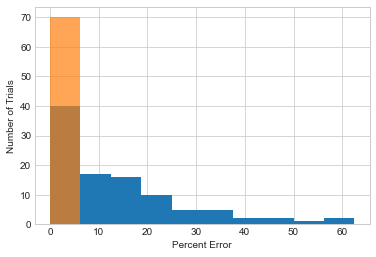

In [11]:
# k = 10; global sensitivity is *much* better
plot_results(10)
plt.xlabel('Percent Error')
plt.ylabel('Number of Trials')
plt.legend();

Text(0, 0.5, 'Number of Trials')

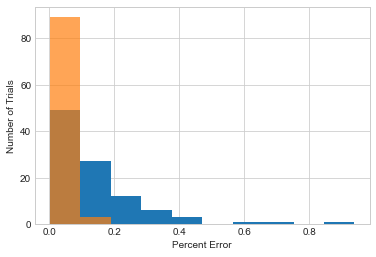

In [12]:
# k = 1000; global sensitivity is still better
plot_results(1000)
plt.xlabel('Percent Error')
plt.ylabel('Number of Trials')
plt.legend();

Text(0, 0.5, 'Number of Trials')

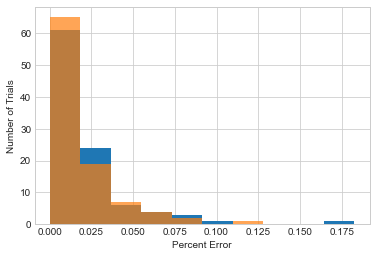

In [13]:
# k = 6000; sample and aggregate is getting close!
plot_results(6000)
plt.xlabel('Percent Error')
plt.ylabel('Number of Trials')
plt.legend();

So - sample and aggregate isn't able to beat our global sensitivity-based approach, but it can get pretty close if you choose the right value for $k$. The big advantage is that sample and aggregate works for *any* function $f$, regardless of its sensitivity; if $f$ is well-behaved, then it's possible to obtain good accuracy from the framework. On the other hand, using sample and aggregate requires the analyst to set the clipping bounds $u$ and $l$, and the number of chunks $k$.